In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-02-06 15:07:37.138858: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
images.ndim, labels.ndim

(3, 3)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [10]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
labels.shape

(503, 512, 512, 1)

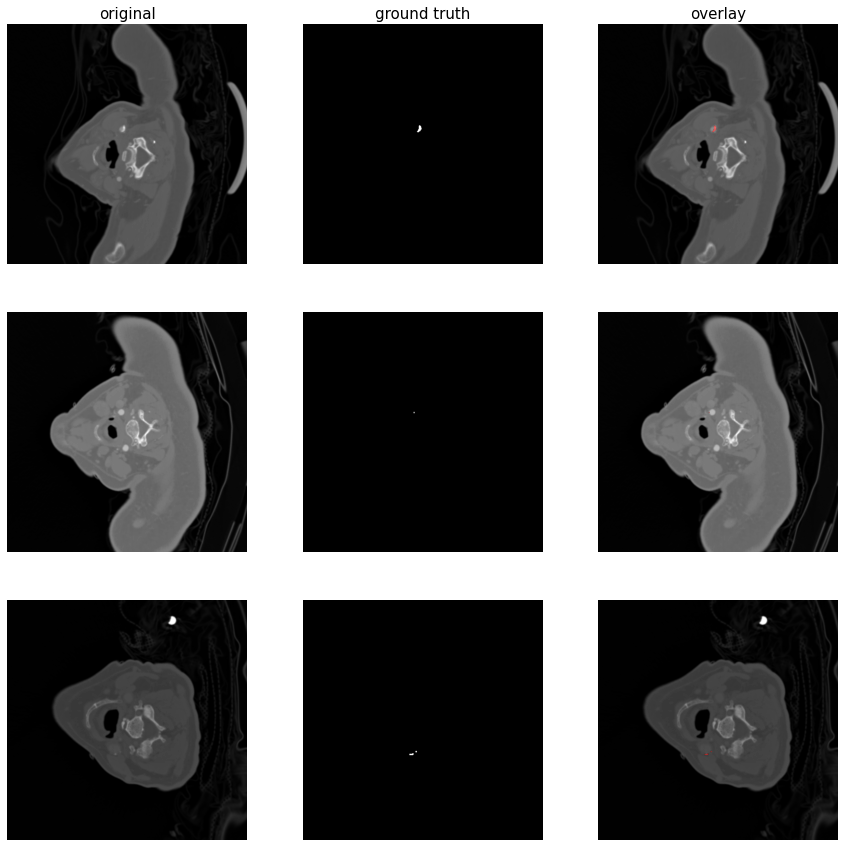

In [13]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [15]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-06 15:07:56.832848: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-06 15:07:56.904247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 15:07:56.904285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 15:07:56.904322: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 15:07:56.904341: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 15:07:56.911114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [16]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [17]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-02-06 15:08:12.146014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 15:08:12.165228: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-02-06 15:08:36.711060: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 15:08:37.810143: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 15:08:37.810494: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 15:08:37.947857: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-06 15:08:38.121156: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-06 15:08:38.848460: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-06 15:08:38.848483: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-06 15:08:38.84884

26/26 [==============================] - 50s 909ms/step - loss: 0.0833 - iou: 0.0010 - iou_thresholded: 0.0017 - val_loss: 0.0041 - val_iou: 0.0010 - val_iou_thresholded: 0.0017
Epoch 2/200
26/26 [==============================] - 18s 699ms/step - loss: 0.0080 - iou: 0.0014 - iou_thresholded: 0.0022 - val_loss: 0.0087 - val_iou: 5.4254e-04 - val_iou_thresholded: 0.0012
Epoch 3/200
26/26 [==============================] - 18s 704ms/step - loss: 0.0059 - iou: 0.0011 - iou_thresholded: 0.0013 - val_loss: 0.0086 - val_iou: 0.0013 - val_iou_thresholded: 0.0017
Epoch 4/200
26/26 [==============================] - 18s 705ms/step - loss: 0.0056 - iou: 0.0011 - iou_thresholded: 0.0026 - val_loss: 0.0027 - val_iou: 0.0014 - val_iou_thresholded: 0.0016
Epoch 5/200
26/26 [==============================] - 18s 712ms/step - loss: 0.0022 - iou: 0.0025 - iou_thresholded: 0.0016 - val_loss: 0.0036 - val_iou: 0.0017 - val_iou_thresholded: 0.0017
Epoch 6/200
26/26 [==============================] - 18s 7

26/26 [==============================] - 18s 698ms/step - loss: 2.9920e-04 - iou: 0.4305 - iou_thresholded: 0.5396 - val_loss: 5.0896e-04 - val_iou: 0.3150 - val_iou_thresholded: 0.3802
Epoch 44/200
26/26 [==============================] - 18s 702ms/step - loss: 2.8969e-04 - iou: 0.4376 - iou_thresholded: 0.5523 - val_loss: 4.9207e-04 - val_iou: 0.3200 - val_iou_thresholded: 0.3848
Epoch 45/200
26/26 [==============================] - 18s 703ms/step - loss: 2.9199e-04 - iou: 0.4431 - iou_thresholded: 0.5608 - val_loss: 5.2770e-04 - val_iou: 0.3086 - val_iou_thresholded: 0.3498
Epoch 46/200
26/26 [==============================] - 18s 705ms/step - loss: 2.7668e-04 - iou: 0.4612 - iou_thresholded: 0.5770 - val_loss: 4.9399e-04 - val_iou: 0.3342 - val_iou_thresholded: 0.4066
Epoch 47/200
26/26 [==============================] - 18s 695ms/step - loss: 2.6051e-04 - iou: 0.4774 - iou_thresholded: 0.5960 - val_loss: 4.7410e-04 - val_iou: 0.3501 - val_iou_thresholded: 0.4275
Epoch 48/200
26/26

26/26 [==============================] - 18s 703ms/step - loss: 7.7986e-05 - iou: 0.7826 - iou_thresholded: 0.8888 - val_loss: 5.9339e-04 - val_iou: 0.4460 - val_iou_thresholded: 0.4698
Epoch 85/200
26/26 [==============================] - 18s 710ms/step - loss: 7.4697e-05 - iou: 0.7849 - iou_thresholded: 0.8907 - val_loss: 6.0423e-04 - val_iou: 0.4490 - val_iou_thresholded: 0.4757
Epoch 86/200
26/26 [==============================] - 18s 702ms/step - loss: 7.0554e-05 - iou: 0.7923 - iou_thresholded: 0.8979 - val_loss: 6.0859e-04 - val_iou: 0.4454 - val_iou_thresholded: 0.4697
Epoch 87/200
26/26 [==============================] - 18s 702ms/step - loss: 6.8510e-05 - iou: 0.7980 - iou_thresholded: 0.9037 - val_loss: 6.0041e-04 - val_iou: 0.4504 - val_iou_thresholded: 0.4729
Epoch 88/200
26/26 [==============================] - 18s 698ms/step - loss: 7.8203e-05 - iou: 0.7902 - iou_thresholded: 0.8891 - val_loss: 6.5970e-04 - val_iou: 0.4306 - val_iou_thresholded: 0.4454
Epoch 89/200
26/26

26/26 [==============================] - 18s 707ms/step - loss: 2.2204e-05 - iou: 0.9220 - iou_thresholded: 0.9869 - val_loss: 7.6082e-04 - val_iou: 0.4757 - val_iou_thresholded: 0.4916
Epoch 126/200
26/26 [==============================] - 18s 701ms/step - loss: 2.0986e-05 - iou: 0.9246 - iou_thresholded: 0.9876 - val_loss: 7.5417e-04 - val_iou: 0.4807 - val_iou_thresholded: 0.4940
Epoch 127/200
26/26 [==============================] - 18s 698ms/step - loss: 2.1642e-05 - iou: 0.9249 - iou_thresholded: 0.9866 - val_loss: 7.8289e-04 - val_iou: 0.4739 - val_iou_thresholded: 0.4844
Epoch 128/200
26/26 [==============================] - 18s 695ms/step - loss: 2.0278e-05 - iou: 0.9269 - iou_thresholded: 0.9877 - val_loss: 7.8822e-04 - val_iou: 0.4740 - val_iou_thresholded: 0.4851
Epoch 129/200
26/26 [==============================] - 18s 705ms/step - loss: 1.9982e-05 - iou: 0.9291 - iou_thresholded: 0.9873 - val_loss: 7.9605e-04 - val_iou: 0.4749 - val_iou_thresholded: 0.4840
Epoch 130/200


26/26 [==============================] - 18s 703ms/step - loss: 7.8574e-06 - iou: 0.9692 - iou_thresholded: 0.9984 - val_loss: 9.1373e-04 - val_iou: 0.4814 - val_iou_thresholded: 0.4880
Epoch 167/200
26/26 [==============================] - 18s 695ms/step - loss: 8.2606e-06 - iou: 0.9691 - iou_thresholded: 0.9977 - val_loss: 9.0291e-04 - val_iou: 0.4844 - val_iou_thresholded: 0.4918
Epoch 168/200
26/26 [==============================] - 18s 705ms/step - loss: 8.3456e-06 - iou: 0.9674 - iou_thresholded: 0.9974 - val_loss: 9.2809e-04 - val_iou: 0.4809 - val_iou_thresholded: 0.4903
Epoch 169/200
26/26 [==============================] - 18s 700ms/step - loss: 9.3543e-06 - iou: 0.9669 - iou_thresholded: 0.9960 - val_loss: 9.3119e-04 - val_iou: 0.4806 - val_iou_thresholded: 0.4874
Epoch 170/200
26/26 [==============================] - 18s 705ms/step - loss: 8.9289e-06 - iou: 0.9669 - iou_thresholded: 0.9963 - val_loss: 9.4282e-04 - val_iou: 0.4796 - val_iou_thresholded: 0.4899
Epoch 171/200


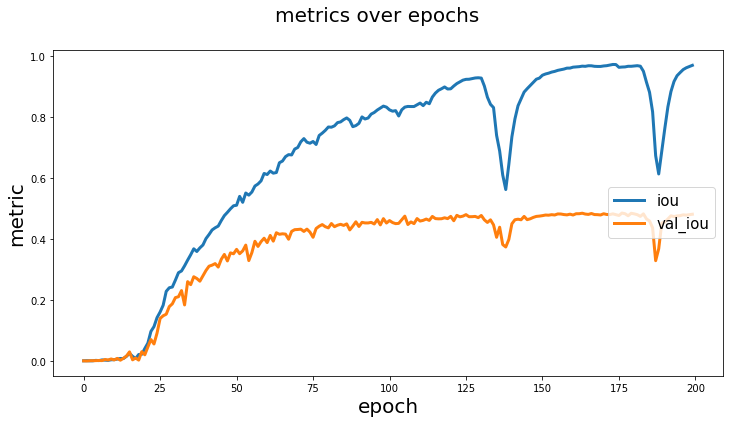

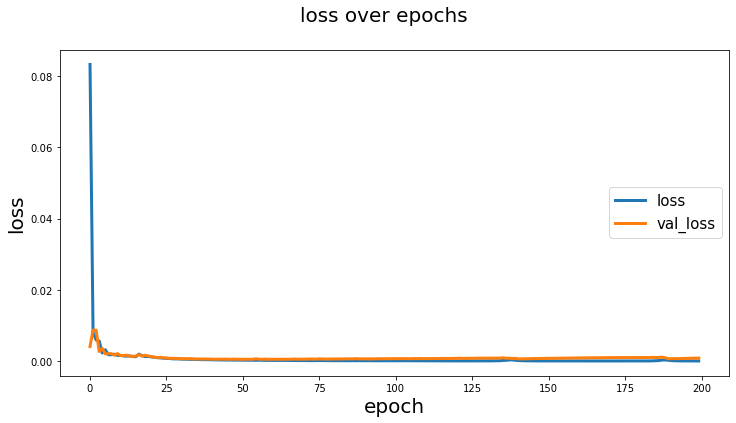

In [20]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [21]:
y_pred = model.predict(X_val)

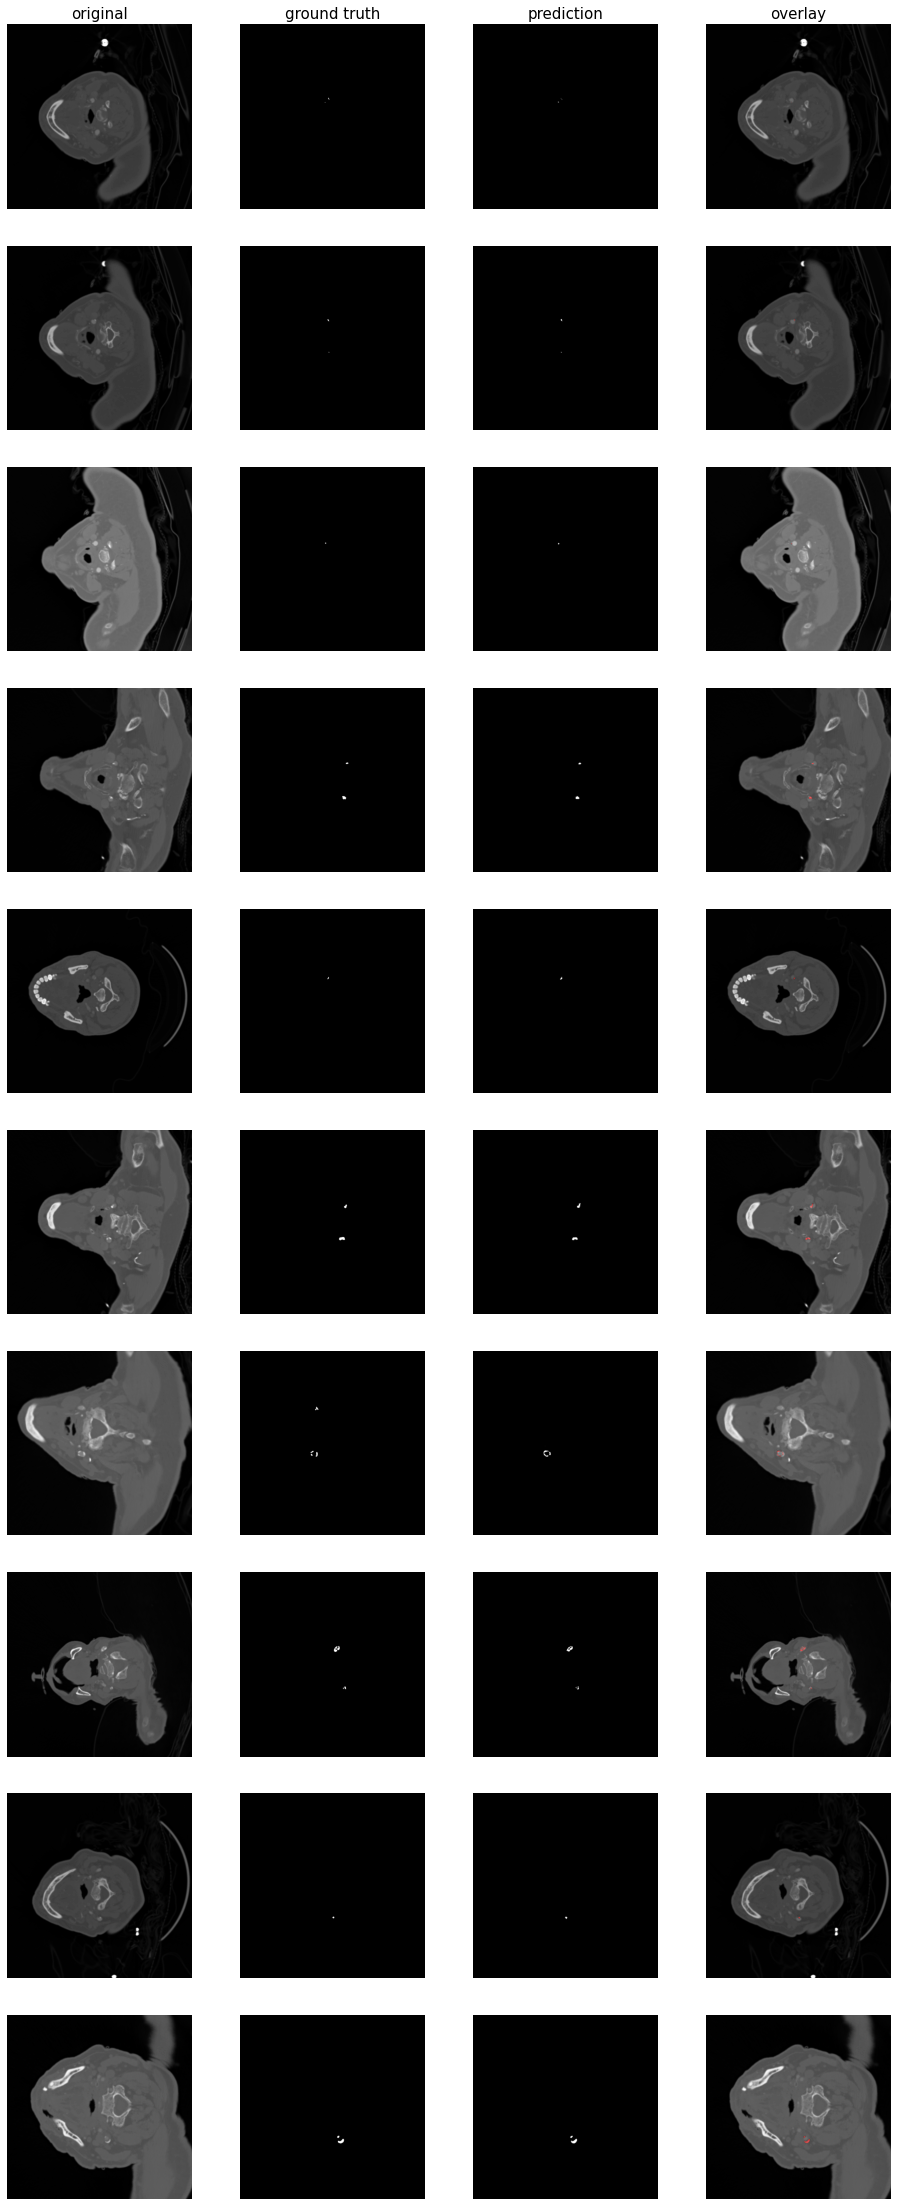

In [22]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

4/4 [==============================] - 2s 350ms/step - loss: 8.1139e-04 - iou: 0.4689 - iou_thresholded: 0.4768
